# Logistic regression on images and why it can (accidentally) work

The goal of this notebook is to look into why one of the simplest classification models, logistic regression, might give surprisingly good results on raw image data.

In [70]:
import numpy as np
import pandas as pd
import os

np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from itertools import product
from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, plot_roc_curve
from sklearn.mixture import GaussianMixture


import warnings

# ignore max iter warning for LR
warnings.filterwarnings("ignore")

## Data loading

In [2]:
def read_file(file, mode="RGB"):
    """
    Load and convert an image from its file path. 
    Modes are RBG (3 channels) and L (greyscale, single channel).
    """
    
    image = Image.open(file)
    image = image.convert(mode)
    
    return np.asarray(image)

#################################
### FOR KAGGLE CLOUD RUN TIME ###
#################################

# open the notebook with https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign

# train_path = "/kaggle/input/skin-cancer-malignant-vs-benign/data/train/"
# test_path = "/kaggle/input/skin-cancer-malignant-vs-benign/data/test/"

##########################
### FOR LOCAL RUN TIME ###
##########################

# unzip the data from https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign

train_path = "archive/data/train/"
test_path = "archive/data/test/"

mode = "L"
width = 224
height = 224

if mode is "RGB":
    channels = 3
elif mode is "L":
    channels = 1
else:
    raise NotImplementedError

    
# training data setup
benign_train_path = train_path + "benign/"
malignant_train_path = train_path + "malignant/"
train_files = [benign_train_path + file for file in os.listdir(benign_train_path)] + \
    [malignant_train_path + file for file in os.listdir(malignant_train_path)]
   
X_train = np.empty((len(train_files), height, width, channels))

# read files and normalize intensity
for i, file in enumerate(train_files):
    X_train[i] = read_file(file, mode).reshape(height, width, channels) / 255 
    
y_train = np.ones((len(train_files), 1))
y_train[:len(os.listdir(benign_train_path))] = 0

X_train_flat = X_train.reshape(X_train.shape[0], -1)

print(X_train.shape, y_train.shape)    

(2637, 224, 224, 1) (2637, 1)


In [3]:
# test data setup
benign_test_path = test_path + "benign/"
malignant_test_path = test_path + "malignant/"
test_files = [benign_test_path + file for file in os.listdir(benign_test_path)] + \
    [malignant_test_path + file for file in os.listdir(malignant_test_path)]

X_test = np.empty((len(test_files), height, width, channels))

for i, file in enumerate(test_files):
    X_test[i] = read_file(file, mode).reshape(height, width, channels) / 255 # normalize intensity
    
y_test = np.ones((len(test_files), 1))
y_test[:len(os.listdir(benign_test_path))] = 0

X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(X_test.shape, y_test.shape)

(660, 224, 224, 1) (660, 1)


The data is fairly balanced so accuracy and area under ROC are reasonable measures for model performance:

In [4]:
y_train.mean()

0.4539249146757679

A few images from the training data:

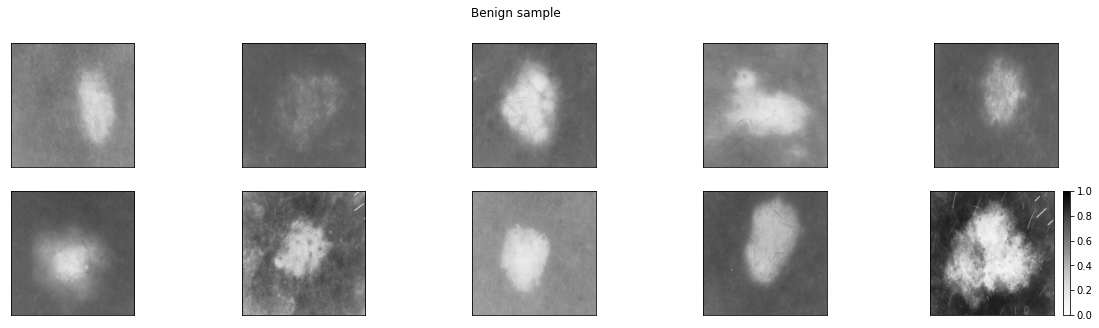

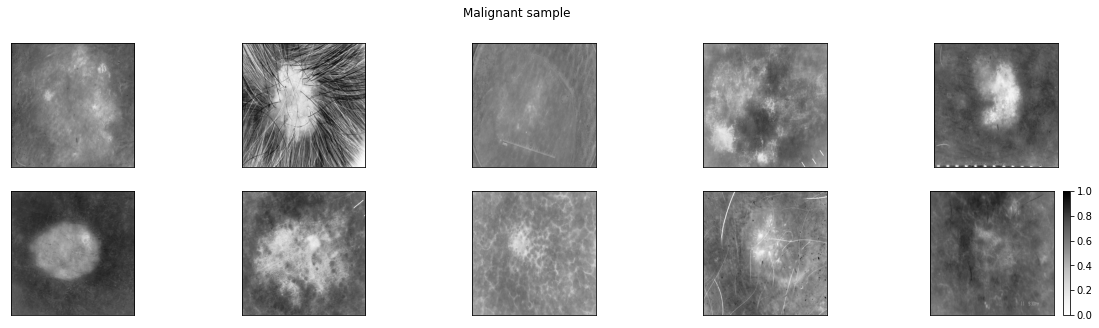

In [5]:
sample_size = 10

np.random.seed(42)

random_idx = np.random.choice(np.where(y_train.ravel() == 0)[0], sample_size)
benign_sample = X_train[random_idx]

plt.figure(figsize=(20, 5))
for i in range(sample_size):
    plt.subplot(2, sample_size//2, i+1)
    plt.imshow(benign_sample[i].reshape(height, width), cmap="Greys", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Benign sample")
plt.colorbar()
plt.show()

random_idx = np.random.choice(np.where(y_train.ravel() == 1)[0], sample_size)
malignant_sample = X_train[random_idx]

plt.figure(figsize=(20, 5))
for i in range(sample_size):
    plt.subplot(2, sample_size//2, i+1)
    plt.imshow(malignant_sample[i].reshape(height, width), cmap="Greys", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Malignant sample")
plt.colorbar()
plt.show()

At this point, we can make a few observations:
- the melanoma tend to be circular;
- the images are brighter in the middle where the melanoma is located (for both classes);
- the outer regions are darker (for both classes);
- the benign melanoma tend to be more uniformly bright (might be subjective).

## Fitting the logistic regression model

We fit a logistic regression next, no hyperparameter tuning and see how it does.

In [6]:
lr = LogisticRegression()
lr.fit(X_train_flat, y_train)

LogisticRegression()

In [7]:
train_pred_proba = lr.predict_proba(X_train_flat)
train_pred = (train_pred_proba[:, 1] >= 0.5).astype(int)
train_report = classification_report(y_train, train_pred)

print(train_report)

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86      1440
         1.0       0.86      0.77      0.81      1197

    accuracy                           0.84      2637
   macro avg       0.84      0.83      0.84      2637
weighted avg       0.84      0.84      0.84      2637



In [8]:
test_pred_proba = lr.predict_proba(X_test_flat)
test_pred = (test_pred_proba[:, 1] >= 0.5).astype(int)
test_report = classification_report(y_test, test_pred)

print(test_report)

              precision    recall  f1-score   support

         0.0       0.69      0.83      0.76       360
         1.0       0.73      0.56      0.64       300

    accuracy                           0.71       660
   macro avg       0.71      0.70      0.70       660
weighted avg       0.71      0.71      0.70       660



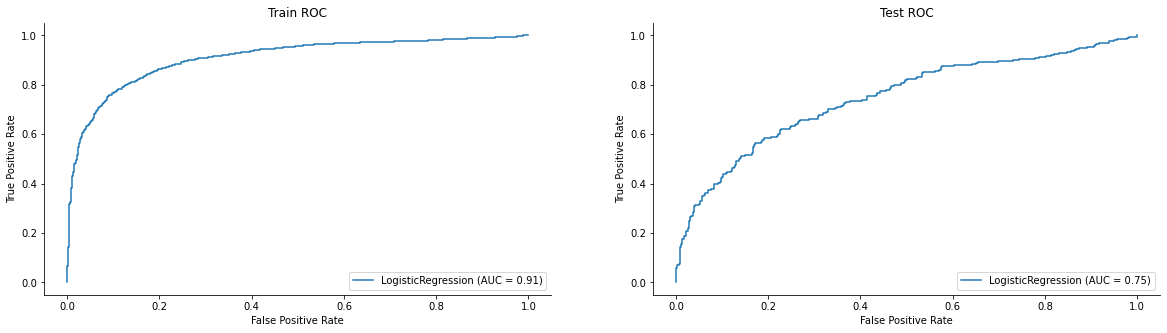

In [9]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 2, 1)
plot_roc_curve(lr, X_train_flat, y_train, ax=ax)
plt.title("Train ROC")
sns.despine()

ax = plt.subplot(1, 2, 2)
plot_roc_curve(lr, X_test_flat, y_test, ax=ax)
plt.title("Test ROC")
sns.despine()

plt.show()

The model is surprisingly good on even the test set:
- 71% overall accuracy,
- 56% of the malignant images are correctly classified as malignant,
- 73% of our malignant predictions are correct. 

So there must be some pixels and simple (linear) pixel combinations which are highly indicative of a malignant tumor in the data set. Let's see a few ways to understand which are these.

## Feature importance - pixel statistics 

Simply looking at the mean and variance per pixel reveals some differences among the classes. Recall that 
- pixel values around **0 are white**, and
- pixel values around **1 are black**.

In [10]:
X_train_benign = X_train[y_train.ravel() == 0]
benign_mean = X_train_benign.mean(axis=0).reshape(height, width) 

X_train_malignant = X_train[y_train.ravel() == 1]
malignant_mean = X_train_malignant.mean(axis=0).reshape(height, width)

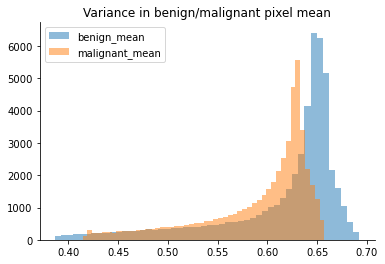

In [11]:
plt.hist(benign_mean.ravel(), bins=50, alpha=0.5, label="benign_mean")
plt.hist(malignant_mean.ravel(), bins=50, alpha=0.5, label="malignant_mean")
plt.legend()
plt.title("Variance in benign/malignant pixel mean")
sns.despine()
plt.show()

Benign images have a higher mean that shows as a bit darker overall images. Otherwise, both distributions are left-skewed.

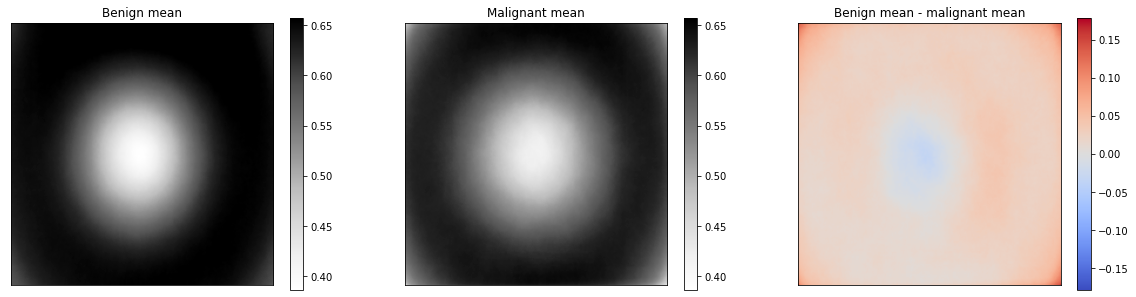

In [12]:
vmin = min(benign_mean.min(), malignant_mean.min())
vmax = min(benign_mean.max(), malignant_mean.max())

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(benign_mean, cmap="Greys", vmin=vmin, vmax=vmax)
plt.title("Benign mean")
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(malignant_mean, cmap="Greys", vmin=vmin, vmax=vmax)
plt.title("Malignant mean")
plt.xticks([])
plt.yticks([])
plt.colorbar()


mean_diff = benign_mean - malignant_mean
lim = np.abs(mean_diff).max()

plt.subplot(1, 3, 3)
plt.imshow(mean_diff, cmap="coolwarm", vmin=-lim, vmax=lim)
plt.title("Benign mean - malignant mean")
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.show()

Now this is really interesting: 
- there is a distinct decrease in the mean pixel intensity for malignant samples at the corners (also the red corners on the difference plot). **Malignant images are darker at the corners.**
- it also looks like that the center region of small mean values for the benign samples is more concentrated (hence the bright red halo on the difference plot). 
- Malignant plots tend to be brighter in the center too, which shows in the blueish center in the difference plot.

Note that we scaled the color map to highlight these trends, otherwise the images are much less drastic (see below).

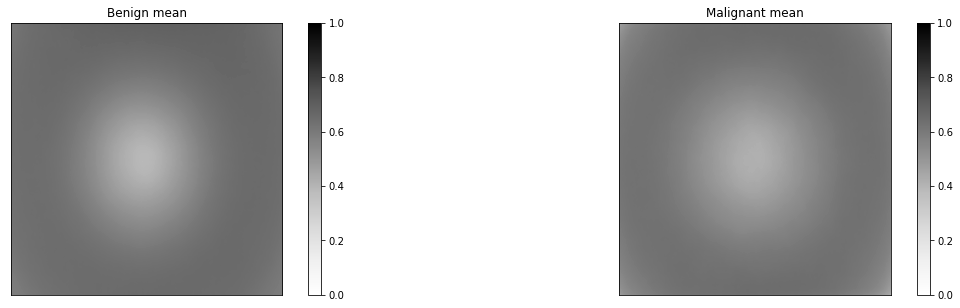

In [13]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.imshow(benign_mean, cmap="Greys", vmin=0, vmax=1)
plt.title("Benign mean")
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(malignant_mean, cmap="Greys", vmin=0, vmax=1)
plt.title("Malignant mean")
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.show()

Now, let's look at the per-pixel standard deviations:

In [14]:
benign_std = X_train_benign.reshape((X_train_benign.shape[0], -1)).std(axis=0).reshape(height, width)
malignant_std = X_train_malignant.reshape((X_train_malignant.shape[0], -1)).std(axis=0).reshape(height, width)

In [15]:
benign_std.mean(), benign_std.std()

(0.11813512942797473, 0.023841325293356485)

In [16]:
malignant_std.mean(), malignant_std.std()

(0.1517035839012464, 0.016690740793795057)

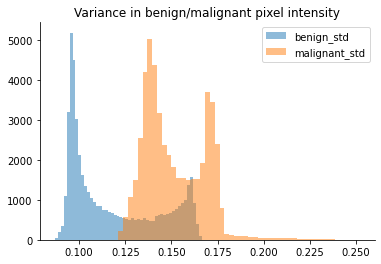

In [17]:
plt.figure()
plt.hist(benign_std.ravel(), bins=50, alpha=0.5, label="benign_std")
plt.hist(malignant_std.ravel(), bins=50, alpha=0.5, label="malignant_std")
plt.legend()
plt.title("Variance in benign/malignant pixel intensity")
sns.despine()
plt.show()

In malignant images, the pixels tend to show ~25% higher variance (0.12 vs 0.15). The double mode in both distributions are quite interesting, my guess is that the central pixels show the high variance and the outer pixel positions give the big peak in the histogram as the low variance pixels. We can verify this by fitting a Gaussian mixture model on these distributions:

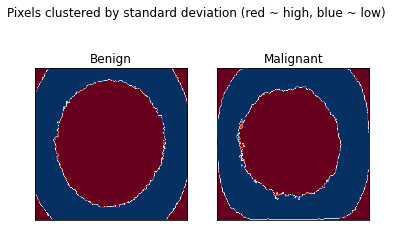

In [71]:
benign_gmm = GaussianMixture(n_components=2, covariance_type="full").fit(benign_std.reshape(-1, 1))
benign_cluster = benign_gmm.predict(benign_std.reshape(-1, 1))

# make sure the higher mean gets label 0 ~ red in imshow
benign_map = np.where(benign_gmm.means_ == benign_gmm.means_.min(), "low", "high").ravel()

if benign_map[1] == "high":
    benign_cluster = 1 - benign_cluster

malignant_gmm = GaussianMixture(n_components=2, covariance_type="full").fit(malignant_std.reshape(-1, 1))
malignant_cluster = malignant_gmm.predict(malignant_std.reshape(-1, 1))

# make sure the higher mean gets label 0 ~ red in imshow
malignant_map = np.where(malignant_gmm.means_ == malignant_gmm.means_.min(), "low", "high").ravel()

if malignant_map[1] == "high":
    malignant_cluster = 1 - malignant_cluster
    
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(benign_cluster.reshape(224, 224), cmap="RdBu")
plt.title(f"Benign")
#plt.colorbar()
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(malignant_cluster.reshape(224, 224), cmap="RdBu")
plt.title(f"Malignant")
#plt.colorbar()
plt.xticks([])
plt.yticks([])

plt.suptitle("Pixels clustered by standard deviation (red ~ high, blue ~ low)")
plt.show()

Almost, actually the corners show high variance too, not just the center positions. Note that, just looking at the samples from our fitted mixture model, we are not perfectly capturing the distributions:

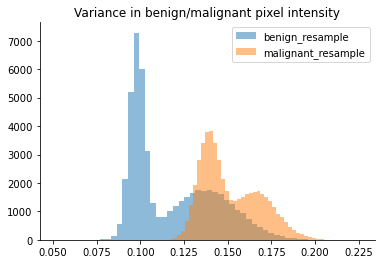

In [76]:
benign_resample = benign_gmm.sample(n_samples = 224**2)[0]
malignant_resample = malignant_gmm.sample(n_samples = 224**2)[0]

plt.figure()
plt.hist(benign_resample, bins=50, alpha=0.5, label="benign_resample")
plt.hist(malignant_resample, bins=50, alpha=0.5, label="malignant_resample")
plt.legend()
plt.title("Variance in benign/malignant pixel intensity")
sns.despine()
plt.show()

Now, let's see how the variance show up on the image grid:

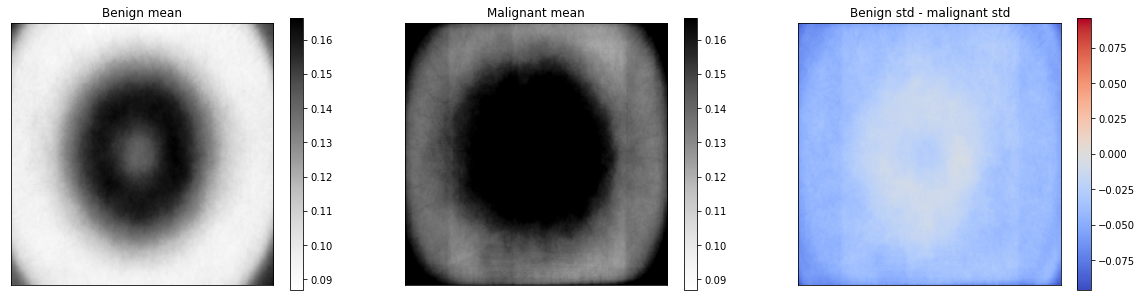

In [18]:
vmin = min(benign_std.min(), malignant_std.min())
vmax = min(benign_std.max(), malignant_std.max())

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.imshow(benign_std, cmap="Greys", vmin=vmin, vmax=vmax)
plt.title("Benign mean")
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(malignant_std, cmap="Greys", vmin=vmin, vmax=vmax)
plt.title("Malignant mean")
plt.xticks([])
plt.yticks([])
plt.colorbar()

std_diff = benign_std - malignant_std
lim = np.abs(std_diff).max()

plt.subplot(1, 3, 3)
plt.imshow(std_diff, cmap="coolwarm", vmin=-lim, vmax=lim)
plt.title("Benign std - malignant std")
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.show()

Again, these scaled plots of the pixel variances show some interesting patterns that somewhat proves our first observation about malignant melanoma:
- malignant melanoma are much less uniform and hence show higher variance (of course, it could also be that malignant images are less centered which can account for higher variance);
- benign melanoma are more uniform (look at the bright center showing low variance);
- both classes have little variance in a concentric region and higher variance around the corners;
- not sure what made the vertical stripes in the malignant plot.

The difference plot is also interesting and shows higher the higher center variance for the malignant class but similar variance at the edge of the melanoma (the bright halo in the difference plot).

## Feature importance - correlation with the target

Now, let's contrast the images with the target and see how they correlate:

In [19]:
corrcoeffs = np.empty(X_train_flat.shape[1])

# TODO: should be vectorized properly
for i in range(X_train_flat.shape[1]):
    corrcoeffs[i] = np.corrcoef(X_train_flat[:, i], y_train.ravel())[0, 1]

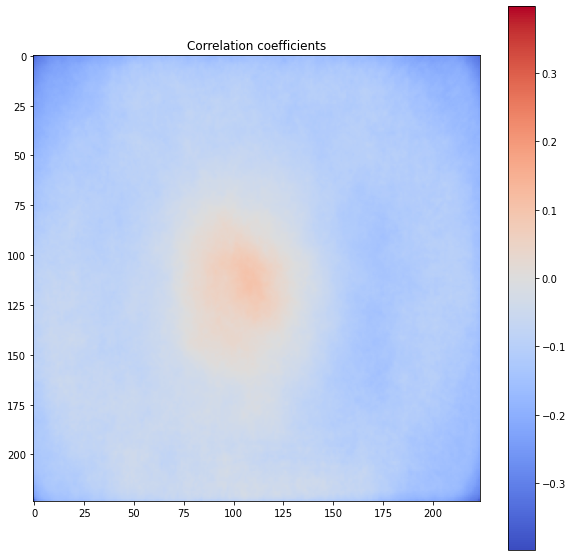

In [20]:
lim = np.abs(corrcoeffs).max()

plt.figure(figsize=(10, 10))
plt.imshow(corrcoeffs.reshape(224, 224), cmap="coolwarm", vmin=-lim, vmax=lim)
plt.colorbar()
plt.title("Correlation coefficients")
plt.show()

First of all, just note how smooth the image is: this is because there is a strong spatial autocorrelation in image data. Nearby pixels tend to have similar values so they are similarly correlated to a third variable too (to the target in this case).

Note:
- the darker blue corners indicate negative correlation: the higher pixel values we see there (the darker the pixels are), the less likely we have a malignant melanoma on the image. This is nicely in line with our previous observations.
- positive correlation in the center: the darker the image in the center, the more likely it is a malignant melanoma.

The crescent light blue pattern is also interesting on the right hand side of the correlation plot.


## Feature importance - model coefficients

As note above, our features are highly correlated so the model coefficients and p-values are not necessarily a reliable measure of feature importance. Nonetheless, we can take a look:

In [21]:
coeff = lr.coef_.reshape(224, 224)

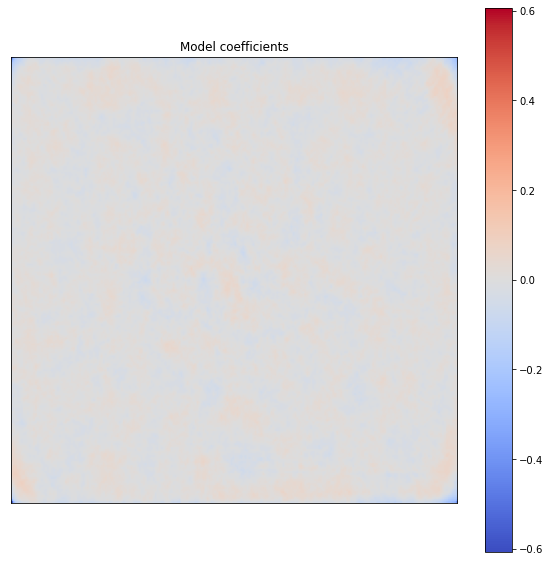

In [22]:
lim = np.abs(coeff).max()

plt.figure(figsize=(10, 10))
plt.imshow(coeff, cmap="coolwarm", vmin=-lim, vmax=lim)
plt.colorbar()
plt.title("Model coefficients")
plt.xticks([])
plt.yticks([])
plt.show()

Not too telling but the corners do stand out a bit with the highest negative coefficients. So darker corners (higher pixel values) will drive down the predicted likelihood of class 1 (malignant). This is again in line with our observed brighter corners for malignant images.

## Refitting on the corners

All the observations so far support the hypothesis that the model is not learning anything about melanoma per se, just taking advantage of the bias in the data recording: malignant images tend to be brigther in the corners.

We'll further validate this by refitting the model on just the corner pixels:

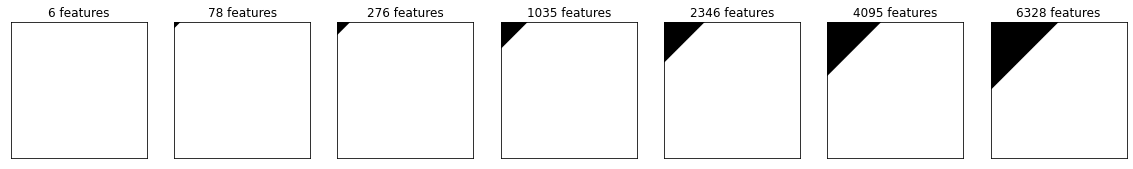

In [23]:
def get_corner_mask(pct, height, width):
    corner_mask = np.zeros((height, width))
    corner_pos = np.array([(i, j) for i, j in product(range(height), range(width)) if i+j < height*pct])
    corner_mask[corner_pos[:, 0], corner_pos[:, 1]] = 1
    
    return corner_mask


pcts = [0.01, 0.05, 0.10, 0.20, 0.3, 0.4, 0.5]
num_features = []

plt.figure(figsize=(20, 5))
for i, pct in enumerate(pcts):
    corner_mask = get_corner_mask(pct, height, width)
    num_features.append(int(corner_mask.sum()))
    
    plt.subplot(1, len(pcts), i+1)
    plt.imshow(corner_mask, cmap="Greys")
    plt.title(f"{num_features[-1]} features")
    plt.xticks([])
    plt.yticks([])
plt.show()

In [24]:
train_results = dict()
test_results = dict()

for i, pct in tqdm(enumerate(pcts)):
    corner_mask = get_corner_mask(pct, height, width)
    corner_mask = corner_mask.reshape(-1).astype(bool)
    X_train_masked = X_train_flat[:, corner_mask]
    X_test_masked = X_test_flat[:, corner_mask]
    
    lr = LogisticRegression()
    lr.fit(X_train_masked, y_train)

    train_pred_proba = lr.predict_proba(X_train_masked)
    train_pred = (train_pred_proba[:, 1] >= 0.5).astype(int)
    train_results[pct] = classification_report(train_pred, y_train, output_dict=True)
    train_results[pct]["rocauc"] = roc_auc_score(y_train, train_pred_proba[:, 1])
    
    test_pred_proba = lr.predict_proba(X_test_masked)
    test_pred = (test_pred_proba[:, 1] >= 0.5).astype(int)
    test_results[pct] = classification_report(y_test, test_pred, output_dict=True)
    test_results[pct]["rocauc"] = roc_auc_score(y_test, test_pred_proba[:, 1])


In [25]:
df = pd.DataFrame()
for pct in pcts:
    current_df = pd.DataFrame(test_results[pct])\
        .reset_index().melt(id_vars=["index"], value_vars=["0.0", "1.0"])\
        .rename({"index": "metric", "variable": "class"}, axis=1)
    current_df = current_df.append({"metric": "accuracy", 
                                    "class": np.nan, 
                                    "value": test_results[pct]["accuracy"], 
                                    "pct": pct}, ignore_index=True)
    current_df = current_df.append({"metric": "rocauc", 
                                    "class": np.nan, 
                                    "value": test_results[pct]["rocauc"], 
                                    "pct": pct}, ignore_index=True)
    current_df["pct"] = pct
    df = pd.concat([df, current_df])
df

,metric,class,value,pct
0,precision,0.0,0.672304,0.01
1,recall,0.0,0.883333,0.01
2,f1-score,0.0,0.763505,0.01
3,support,0.0,360.000000,0.01
4,precision,1.0,0.775401,0.01
...,...,...,...,...
5,recall,1.0,0.556667,0.50
6,f1-score,1.0,0.620818,0.50
7,support,1.0,300.000000,0.50
8,accuracy,NaN,0.690909,0.50


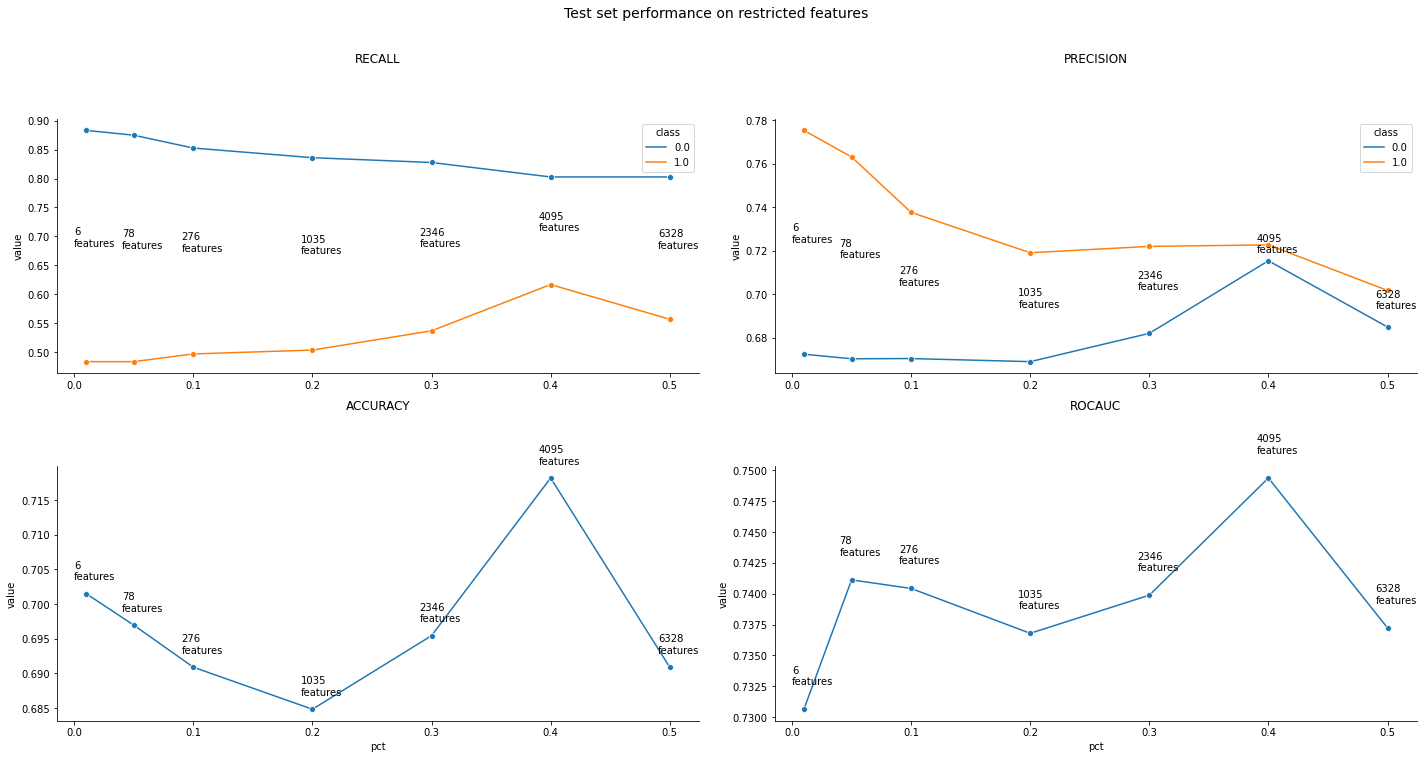

In [26]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
metric = "recall"
plot_df = df.loc[(df.metric == metric), ["pct", "value", "class"]]
ax = sns.lineplot(x = "pct", y = "value", data=plot_df, hue="class", marker="o")

# text annotation
for n, x, y in zip(num_features, 
                   plot_df.loc[plot_df["class"] == "0.0", "pct"].values, 
                   plot_df.groupby("pct").mean()["value"].values):
    ax.text(float(x)-0.01, float(y), f"{str(n)}\nfeatures", horizontalalignment='left', size='medium', color='black')

plt.title(metric.upper(), y=1.2)
plt.xlabel("")
sns.despine()

plt.subplot(2, 2, 2)
metric = "precision"
plot_df = df.loc[(df.metric == metric), ["pct", "value", "class"]]
ax = sns.lineplot(x = "pct", y = "value", data=plot_df, hue="class", marker="o")

# text annotation
for n, x, y in zip(num_features, 
                   plot_df.loc[plot_df["class"] == "0.0", "pct"].values, 
                   plot_df.groupby("pct").mean()["value"].values):
    ax.text(float(x)-0.01, float(y), f"{str(n)}\nfeatures", horizontalalignment='left', size='medium', color='black')

plt.title(metric.upper(), y=1.2)
plt.xlabel("")
sns.despine()

plt.subplot(2, 2, 3)
metric = "accuracy"
plot_df = df.loc[(df.metric == metric), ["pct", "value"]]
ax = sns.lineplot(x = "pct", y = "value", data=plot_df, marker="o")

# text annotation
for n, x, y in zip(num_features, plot_df["pct"].values, plot_df["value"].values):
    ax.text(float(x)-0.01, float(y)+0.002, f"{str(n)}\nfeatures", horizontalalignment='left', size='medium', color='black')

plt.title(metric.upper(), y=1.2)
sns.despine()

plt.subplot(2, 2, 4)
metric = "rocauc"
plot_df = df.loc[(df.metric == metric), ["pct", "value"]]
ax = sns.lineplot(x = "pct", y = "value", data=plot_df, marker="o")

# text annotation
for n, x, y in zip(num_features, plot_df["pct"].values, plot_df["value"].values):
    ax.text(float(x)-0.01, float(y)+0.002, f"{str(n)}\nfeatures", horizontalalignment='left', size='medium', color='black')

plt.title(metric.upper(), y=1.2)
sns.despine()

plt.tight_layout()
plt.suptitle("Test set performance on restricted features", y=1.05, fontsize=14)
plt.show()

Only on 6 corner pixels, we already achieve ~70% accuracy, essentially the same as on the whole image. We see that we can gain some extra recall for class 1 with more features but precision is negatively affected by the same change. The initial ROCAUC of 0.73 is only barely increased to two 0.75 with more features. Given how close these number are, cross-validation would be the proper way to analyze these changes.

In any case, this still shows that the model gains most of its predictive power from checking the brightness of the corners, which has nothing to do of course with the problem of detecting malignant melanoma.

## Sensitivity to out-of-distribution samples 

Finally, we can look at our original model, and evaluate it on images where the corners were changed, a sort of **adversarial example**.

In [27]:
lr = LogisticRegression()
lr.fit(X_train_flat, y_train)

LogisticRegression()

In [28]:
pred_proba = lr.predict_proba(X_test_flat)
pred = (pred_proba[:, 1] >= 0.5).astype(int)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.69      0.83      0.76       360
         1.0       0.73      0.56      0.64       300

    accuracy                           0.71       660
   macro avg       0.71      0.70      0.70       660
weighted avg       0.71      0.71      0.70       660



In [29]:
corner_mask = get_corner_mask(0.01, 224, 224).reshape(-1)
X_test_masked = X_test_flat * (1-corner_mask) # keep everything as is but zero out the corner
X_test_masked = X_test_masked + corner_mask # black out the corner wiht adding 1's

In [30]:
pred_proba = lr.predict_proba(X_test_masked)
pred = (pred_proba[:, 1] >= 0.5).astype(int)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.65      0.91      0.76       360
         1.0       0.79      0.42      0.55       300

    accuracy                           0.69       660
   macro avg       0.72      0.66      0.65       660
weighted avg       0.72      0.69      0.66       660



**There is a 14% drop in recall for malignant images if we blacken 6 pixels in a single corner of the images.** This shows how sensitive the model is to changes in the image which are not even detectable at first sight.

## Appendix - permutation importance 

Another standard way of testing the importance of a feature is to permute its values across the samples and see how much this degrades the model performance. The more accuracy we lose with the permutation the more important the feature was. In this process, it is important 

- to average out the across multiple permutations, and
- to permute highly correlated features together.

So, we shall group spatially near features together (with a sliding window across the 2d image) and permute these pixel values across samples together.

In [56]:
from itertools import product


window = 50
width, height = 224, 224


def get_window_idx(i, j, window=50):

    start_i = max(i-window, 0)
    end_i = min(i+window, width)

    start_j = max(j-window, 0)
    end_j = min(j+window, height)

    return start_i, end_i, start_j, end_j

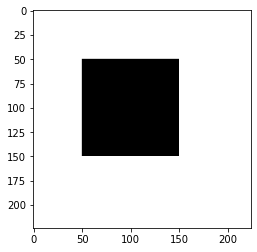

In [57]:
# sanity check

i, j = 100, 100

start_i, end_i, start_j, end_j = get_window_idx(i, j)
window_pos = np.asarray([[start_i + k, start_j + l] for k, l in product(range(window), repeat=2)])

a = np.zeros((height, width))
a[start_i:end_i, start_j:end_j] = 1

plt.imshow(a, cmap="Greys", vmin=0, vmax=1);

In [33]:
# testing the shuffling loop
# TODO: vectorize
x = np.arange(16).reshape(4,4)
a = [True, False, True, False]
for i in np.where(a)[0]:
    np.random.shuffle(x[:, i])
x

array([[12,  1,  6,  3],
       [ 8,  5, 10,  7],
       [ 4,  9, 14, 11],
       [ 0, 13,  2, 15]])

In [77]:
step_size = 50
height_pos = np.arange(0, height, step_size)
width_pos = np.arange(0, width, step_size)

# calculate base score
lr = LogisticRegression()
lr.fit(X_train_flat, y_train.ravel())

train_pred_proba = lr.predict_proba(X_train_flat)
train_pred = (train_pred_proba[:, 1] >= 0.5).astype(int)
base_score = accuracy_score(y_train.ravel(), train_pred)

print(f"Base score: {base_score}")

importance = np.empty((height_pos.shape[0], width_pos.shape[0]))

for i, h in enumerate(height_pos):
    for j, w in enumerate(width_pos):
        # build the mask for the pixel positions around h, w
        start_i, end_i, start_j, end_j = get_window_idx(h, w)
        mask = np.zeros((height, width))
        mask[start_i:end_i, start_j:end_j] = 1

        # shuffle the selected features
        X_train_flat_shuffled = X_train_flat.copy()
        
        # shuffle col's independently
        # TODO: vectorize this properly
        for col in np.where(mask.reshape(-1) == 1)[0]:
            np.random.shuffle(X_train_flat_shuffled[:, col])

        # fit and score on shuffled data
        lr_shuffled = LogisticRegression()
        lr_shuffled.fit(X_train_flat_shuffled, y_train.ravel())
        train_pred_proba = lr_shuffled.predict_proba(X_train_flat_shuffled)
        train_pred = (train_pred_proba[:, 1] >= 0.5).astype(int)
        score = accuracy_score(y_train.ravel(), train_pred)
        
        print(f"Current score: {score}", end="\r")
        
        # the importance is the base_score minus the current score
        importance[i, j] = base_score - score

Base score: 0.8395904436860068


In [80]:
# accuracies on the shuffled data set
base_score - importance

array([[0.90140311, 0.92150171, 0.93439515, 0.88623436, 0.91240046],
       [0.91277967, 1.        , 1.        , 1.        , 1.        ],
       [0.91050436, 0.99317406, 0.98824422, 1.        , 1.        ],
       [0.91429655, 0.99962078, 0.98331437, 0.99848312, 0.97421312],
       [0.86234357, 0.99241562, 0.93704968, 0.97952218, 0.90974592]])

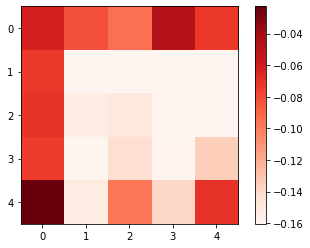

In [78]:
# importance = decrease compared to baseline accuracy
plt.figure()
plt.imshow(importance, cmap="Reds")
plt.colorbar()
plt.show()

There are a few unexpected results on this plot:
- all the values we got are negative meaning that the models on the shuffled data were actually better performing;
- the highest improvements were coming from shuffling the middle portion of the data.

With the height positions at 1, we were shuffling for example these pixel positions:

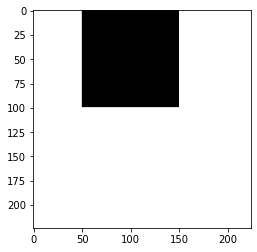

In [58]:
h, w = height_pos[1], width_pos[2]
start_i, end_i, start_j, end_j = get_window_idx(h, w)
mask = np.zeros((height, width))
mask[start_i:end_i, start_j:end_j] = 1

plt.figure()
plt.imshow(mask, cmap="Greys")
plt.show()

This evaluation might not be totally fair since at the corner positions we shuffle a smaller number of features features. Finally, I am curious what would happen if we shuffle all corner positions:

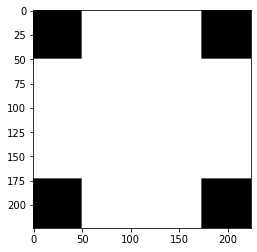

In [63]:
hs = [0, 0, height-1, height-1]
ws = [0, width-1, 0, width-1]

corner_mask = np.zeros((height, width))

for h, w in zip(hs, ws):
    start_i, end_i, start_j, end_j = get_window_idx(h, w)
    mask = np.zeros((height, width))
    mask[start_i:end_i, start_j:end_j] = 1
    corner_mask += mask

plt.figure()
plt.imshow(corner_mask, cmap="Greys")
plt.show()

In [64]:
# shuffle the selected features
X_train_flat_shuffled = X_train_flat.copy()

# shuffle col's independently
# TODO: vectorize this properly
for col in np.where(corner_mask.reshape(-1) == 1)[0]:
    np.random.shuffle(X_train_flat_shuffled[:, col])

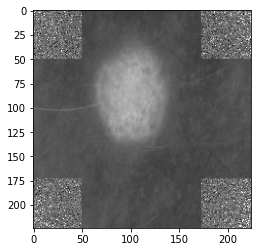

In [65]:
# sanity check
img = X_train_flat_shuffled.reshape(-1, height, width)[0, :, :]

plt.figure()
plt.imshow(img, cmap="Greys", vmin=0, vmax=1)
plt.show()

In [66]:
# fit and score on shuffled data
lr_shuffled = LogisticRegression()
lr_shuffled.fit(X_train_flat_shuffled, y_train.ravel())

LogisticRegression()

In [67]:
train_pred_proba = lr.predict_proba(X_train_flat_shuffled)
train_pred = (train_pred_proba[:, 1] >= 0.5).astype(int)
train_report_shuffled = classification_report(y_train, train_pred)

print(train_report_shuffled)

              precision    recall  f1-score   support

         0.0       0.66      0.62      0.64      1440
         1.0       0.57      0.61      0.59      1197

    accuracy                           0.62      2637
   macro avg       0.61      0.62      0.61      2637
weighted avg       0.62      0.62      0.62      2637



In [68]:
print(train_report)

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86      1440
         1.0       0.86      0.77      0.81      1197

    accuracy                           0.84      2637
   macro avg       0.84      0.83      0.84      2637
weighted avg       0.84      0.84      0.84      2637



As we expected, shuffling all corner positions results in a serious loss in accuracy and malignant $F_1$ score (~22%).

## Conclusions 

Linear models might perform well on image or other complex data sets at first sight but as we saw it here, the reason could be that the model is picking up on spurious correlations that are very specific to the training data distribution. By looking at the pixel intensities and model coefficients, we saw that a significant portion of the model's predictive power was coming from detecting if the corner pixels were dark versus light, clearly irrelevant to the actual task at hand.